In [65]:
import os
import cv2
import numpy as np
import torch

import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from PIL import Image
import matplotlib.pylab as plt

# Importazione dei dati

### Definisco le directory

In [33]:
images = "Data/cat_dog/"
labels = "Data/cat_dog.csv"

### Estraggo le immagini e i nomi dei file per cerare il dataset

In [34]:
img_path = [images+img for img in os.listdir(images)]

print(img_path[:5])
print(len(img_path))

['Data/cat_dog/cat.0.jpg', 'Data/cat_dog/cat.1.jpg', 'Data/cat_dog/cat.10.jpg', 'Data/cat_dog/cat.100.jpg', 'Data/cat_dog/cat.1000.jpg']
25000


#### Essendo che la label ("cat"/"dog") è già presente nel nome dell'immagine posso tralasciare l'utilizzo del csv
Mi assicuro quindi che i nomi delle immagini siano coerenti

In [35]:
with open(labels, 'r') as f:
    for line in f:
        if (line[:3] == 'dog' and line[-2] != '1') or (line[:3] == 'cat' and line[-2] != '0'):
            raise Exception

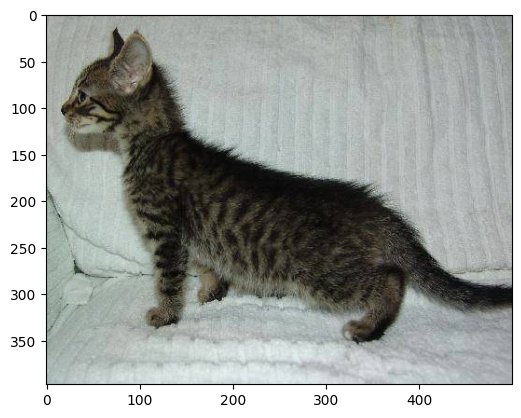

In [73]:
import random

with Image.open(img_path[random.randint(0, 24999)]) as img:
    plt.imshow(img)

### Definisco la classe Dataset

In [69]:
class CatDogDataset(Dataset):
    def __init__(self, images_path, device='cuda' if torch.cuda.is_available() else 'cpu', image_size=(512, 512), augmentation=True):
        self.images = images_path
        self.device = device
        self.img_size = image_size
        self.augmentation = augmentation
        
        self.transform = transforms.Compose([
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
            transforms.Normalize
        ])
        
        if self.augmentation:
            self.image_augmentation = transforms.Compose([
                transforms.RandomRotation(90),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomAdjustSharpness(2)
            ])
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = '1' if image.split('/')[-1][:3] == 'dog' else '0'
        
        if self.augmentation:
            image = self.image_augmentation(image)
        
        image = self.transform(image).to(device)
        
        return image, label
    
    def __len__(self):
        return len(self.images)

In [67]:
train, test = train_test_split(img_path, test_size=0.1, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(f'Train size: {len(train)}, Eval size: {len(val)}, Test size: {len(test)}')

Train size: 18000, Eval size: 4500, Test size: 2500


In [70]:
train_dataset = CatDogDataset(train, augmentation=True)
val_dataset = CatDogDataset(val, augmentation=True)
test_dataset = CatDogDataset(test, augmentation=False)

In [72]:
toPIL = transforms.ToPILImage()
batch_size = 32

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1)
test_dataloader = DataLoader(test, shuffle=True, batch_size=1)